# Python+OpenCV로 자동차 번호판 영역 추출 및 인식하기

python에 설치한 OpenCV를 활용하여 자동차가 찍힌 사진에서 번호판 영역을 추출하고 pytesseract를 통해 인식하는 과정에 대해 설명합니다.

**OpenCV**(Open Source Computer Vision)은 [오픈 소스 컴퓨터 비전 라이브러리](https://ko.wikipedia.org/wiki/%EB%9D%BC%EC%9D%B4%EB%B8%8C%EB%9F%AC%EB%A6%AC)이다. 원래는 인텔이 개발하였다. 윈도, 리눅스 등의 여러 플랫폼에서 사용할 수 있다. 실시간 이미지 프로세싱에 중점을 둔 라이브러리이다. 

OpenCV는 오픈 소스 컴퓨터 비전 라이브러리로, 영상처리 관련 라이브러리들을 쉽게 사용할 수 있습니다.

영상신호처리는 기계학습과 함께 많이 사용하며 객체 추적, 무인자율주행자동차, 보행자 추적 및 인식, OCR 등 다양하게 활용하고 있는 기술입니다.

여기서 소개할 자동차 번호판 영역 추출 또한 영상신호처리를 이용합니다.

![자동차 번호판 사진](images/Car_Number1.png)

자동차 앞 모습이 찍힌 사진이 있습니다. 이 사진에서 어떻게 19세1004라는 번호판 영역을 추출할 것인지 알아보도록 하겠습니다.  차량 용도나, 종류에 따라 번호판의 색깔이 달라질 수 도 있다보니 색상기반의 추출보단,  윤곽선을 기반으로 찾는 방법을 더 많이 사용합니다.

![윤곽선 적용 자동차 번호판 사진](images/Car_Number2.png)


위 그림 과 같은 번호판의 글자에 윤곽선을 잡아주기 위해 먼저 OpenCV라이브러리를 이용하여 원본 이미지에 전처리 과정을 해주는 것이 필요합니다.

먼저 필요한 패키지를 ``import`` 합니다 

In [1]:
#!/usr/bin/etc python

import cv2
import numpy as np
import pytesseract
from  PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import NoNorm


먼저 컬러 이미지를 Gray 이미지로 바꿔주는 것이 필요합니다. RGB색상 공간으로 볼때, 컬러 이미지의 모든 색은 R(빨간색)+G(녹색)+B(파랑색)의 색깔을 조합해 표현 합니다. 3가지 색상값을 1/3로 나누어 주거나, R,G,B 중 하나의 값만으로 표현하면 Gray 이미지로 표현 할 수 있습니다. 

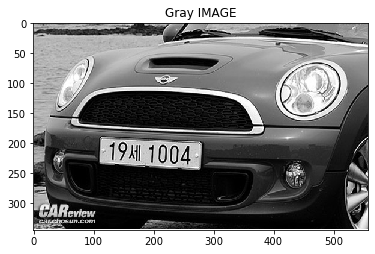

In [2]:
Number='images/Car_Number1.png' 
img=cv2.imread(Number,cv2.IMREAD_COLOR)
copy_img=img.copy()
img2=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
cv2.imwrite('images/gray.jpg',img2)
# showImage = Image.open('images/gray.jpg')
# showImage.show()
plt.imshow(img2, cmap='gray')
plt.title('Gray IMAGE')
plt.show()

Gray 이미지를 얻은 후, 필터를 적용시켜 윤곽선을 더 잘 잡을 수 있도록 합니다.
저는 OpenCV에서 제공하는 가우시안 Blur 필터를 적용 시켰습니다.

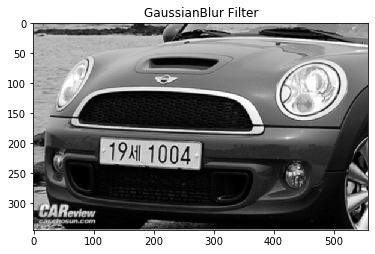

In [3]:
blur = cv2.GaussianBlur(img2,(3,3),0)
cv2.imwrite('images/blur.jpg',blur)
plt.imshow(blur, cmap='gray')
plt.title('GaussianBlur Filter')
plt.show()

가우시안 필터를 적용시키기 전과 후의 차이가 느껴지시는가요? 전체적으로 Smooth해진 느낌을 얻을 수 있습니다. 사람의 눈으로는 크게 차이가 안느껴지실 수 도 있지만, 실제로 엣지검출이나, 영상처리과정에서  큰 영향을 끼치는 것을 확인하실 수 있습니다.

이제 전처리 된 사진에서 엣지를 검출하도록 하겠습니다.

가우시안 필터 이미지에서 Canny Detection을 사용하여 추출된 이미지 입니다. 
![Python](images/CannyDetection_python.png)

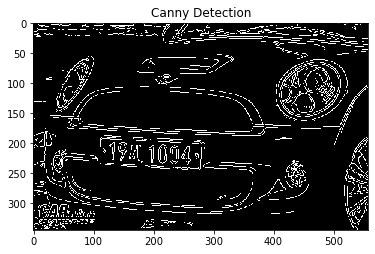

In [4]:
canny=cv2.Canny(blur,100,200)
cv2.imwrite('images/canny.jpg',canny)
plt.imshow(canny, cmap='gray')
plt.title('Canny Detection')
plt.show()

cv2.Canny에 적용되는 Threshold1,2 의 값은 특정 사진에 맞춰 설정해준 값입니다. 이외에도 가우시안 값에 적용시킨 3x3 매트릭스 값도 마찬 가지입니다.  

Edge에 대한 설명을 조금 추가하자면, 흑백영상에서 명암의 밝기 차이에 대한 변화율이라고 생각하시면 됩니다.

![기울기](images/Edge_var.png)

위 그림과 같이 흑백이미지에 대한 미분 값이라고 생각하시면 좋을 꺼 같습니다.

다시 본론으로 돌아가서, 이제 엣지를 추출한 이미지에 대해 cv.findContours함수를 사용하여 canny 이미지에 대해 Contours들을 찾도록 하겠습니다.


```
cnts,contours,hierarchy  = cv2.findContours(canny, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
```
Contours는 같은 에너지를 가지는 점들을 연결 한 선이라고 생각하시면 됩니다.


![Contours설명](images/Contours_desc.png)



OpenCV는 Contour를 찾을때 검은 바탕에 찾는 물체는 흰색으로 설정해주셔야 합니다.



In [5]:
# cnts,contours,hierarchy  = cv2.findContours(canny, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# check OpenCV version
major = cv2.__version__.split('.')[0]
if major == '3':
    cnts, contours, hierarchy = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
else:
    contours, hierarchy = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

전체 이미지에서 Contour의 가로 세로 비율 값과 면적을 통해, 번호판 영역에 벗어난 걸로 추정되는 값들은 제외 시켜주었습니다.

In [6]:
box1=[]
f_count=0
select=0
plate_width=0
          
for i in range(len(contours)):
    cnt=contours[i]
    area = cv2.contourArea(cnt)
    x,y,w,h = cv2.boundingRect(cnt)
    rect_area=w*h  #area size
    aspect_ratio = float(w)/h # ratio = width/height
                  
    if  (aspect_ratio>=0.2)and(aspect_ratio<=1.0)and(rect_area>=100)and(rect_area<=700):
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),1)
        box1.append(cv2.boundingRect(cnt))


그리고 원본 이미지에 적용시키면 아래 와 같은 이미지가 나오게 됩니다.

![](images/Car_Number3.png)

이제 번호판 영역을 추출해야합니다. 위 이미지를 보시면 번호판 영역에는 Rectangle들이 정렬로 모여 있는것을 확인할 수 있습니다. 

![](images/Car_Number4.png)

위 그림의 화살표 처럼 Rectangle과 Rectangle사이 간격과 기울기 값이 일정 범위 안에 들어올 시 카운트를 올리게 됩니다. 노란색 화살표의 경우  Rectangle사이 간격이 좁고 기울기의 차가 적으므로 가장 높은 카운트를 가지게 됩니다.


위의 알고리즘을 적용하기 위해 Contour 배열에 대해 버블정렬을 해줍니다.   

In [7]:
##Buble Sort on python
for i in range(len(box1)): 
    for j in range(len(box1)-(i+1)):
        if box1[j][0]>box1[j+1][0]:
            temp=box1[j]
            box1[j]=box1[j+1]
            box1[j+1]=temp
                         


카운트가 가장 높은 Contour 값을 찾으면 번호판의 시작점이 됩니다.

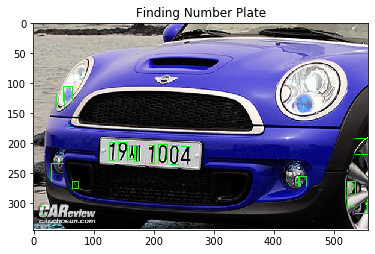

In [8]:
#to find number plate measureing length between rectangles
for m in range(len(box1)):
    count=0
    for n in range(m+1,(len(box1)-1)):
        delta_x=abs(box1[n+1][0]-box1[m][0])
        if delta_x > 150:
            break
        delta_y =abs(box1[n+1][1]-box1[m][1])
        if delta_x ==0:
            delta_x=1
        if delta_y ==0:
            delta_y=1           
        gradient =float(delta_y) /float(delta_x)
        if gradient<0.25:
            count=count+1
    #measure number plate size
    if count > f_count:
        select = m
        f_count = count;
        plate_width=delta_x

cv2.imwrite('images/snake.jpg',img)
plt.imshow(img, cmap='gray')
plt.title('Finding Number Plate')
plt.show()          


번호판의 사이즈부분에 대해서는 아래 코드 처럼 상수 값으로 Offset을 주어서 추출 하였습니다.

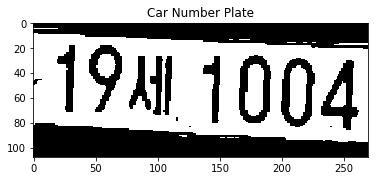

In [9]:
number_plate=copy_img[box1[select][1]-10:box1[select][3]+box1[select][1]+20,box1[select][0]-10:140+box1[select][0]] 
resize_plate=cv2.resize(number_plate,None,fx=1.8,fy=1.8,interpolation=cv2.INTER_CUBIC+cv2.INTER_LINEAR) 
plate_gray=cv2.cvtColor(resize_plate,cv2.COLOR_BGR2GRAY)
ret,th_plate = cv2.threshold(plate_gray,150,255,cv2.THRESH_BINARY)
          
cv2.imwrite('images/plate_th.jpg',th_plate)
plt.imshow(th_plate, cmap='gray')
plt.title('Car Number Plate')
plt.show()          


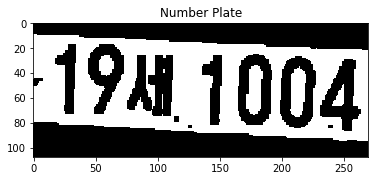

In [10]:
# erode 작업을 통해 검은색 글자 부분을 더 강조해줍니다.
kernel = np.ones((3,3),np.uint8)
er_plate = cv2.erode(th_plate,kernel,iterations=1)
er_invplate = er_plate
cv2.imwrite('images/er_plate.jpg',er_invplate)

plt.imshow(er_invplate, cmap='gray')
plt.title('Number Plate')
plt.show()          



번호판 영역만 추출 한다면 pytesseract로 인식하는 과정은 간단합니다.

In [11]:
# Adding custom options
custom_config = r'--oem 1 --psm 6'
pytesseract.image_to_string(Image.open('images/er_plate.jpg'), lang='kor', config=custom_config)

'194 1004'